## [1. Import Needed Modules](#import) ##
## [2. Read in image files, create equalized histogram images and store](#equalize) ## 
## [3. Read in stored image files,create train, test and valid dataframes ](#makedf) ## 
## [4. Balance the train_df dataframe using trim function](#trim) ##
## [5. Create train, test and validation generators](#generators) ## 
## [6. Create a function to show Training Image Samples](#show) ## 
## [7. Create the Model](#model) ## 
## [8. Create a custom Keras callback to continue or halt training](#callback) ## 
## [9. Instantiate custom callback and create callbacks to control learning rate and early stopping](#callbacks) ##
## [10. Train the model](#train) ##
## [11. Define a function to plot the training data](#plot) ##
## [12. Make predictions on test set, create Confusion Matrix and Classification Report](#result) ##
## [13 Save the model](#save) ##





<a id="import"></a>
# <center>Import Need Modules</center>

In [3]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tqdm import tqdm



<a id="equalize"></a>
# <center>Read in images, equaliize histogram and save to working_dir/histo

In [4]:
sdir=r'../input/3-kinds-of-pneumonia/Curated X-Ray Dataset'
working_dir=r'./'
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
histpath=os.path.join(working_dir, 'hist')# store equalized histogram images in this directory
if os.path.isdir(histpath):
    shutil.rmtree(histpath) # start with an empty directory
os.mkdir(histpath) # create the directory
classlist=os.listdir(sdir) # iteratethrough the classes
for klass in classlist:
    print ('processing class ', klass)
    classpath=os.path.join(sdir, klass)
    dest_classpath=os.path.join(histpath, klass)
    os.mkdir(dest_classpath)# make the class directories
    flist=os.listdir(classpath)
    sampled_list=np.random.choice(flist, size=500, replace=False) # use only 500 images from each class
    for f in tqdm(sampled_list):
        fpath=os.path.join(classpath,f)
        dest_fpath=os.path.join(dest_classpath,f)
        img = cv2.imread(fpath,0) # read in the image
        cl1 = clahe.apply(img) # balance the image histogram
        cv2.imwrite(dest_fpath, cl1) # save the balanced image
        

processing class  Normal


100%|██████████| 500/500 [00:29<00:00, 17.06it/s]


processing class  COVID-19


100%|██████████| 500/500 [00:26<00:00, 18.57it/s]


processing class  Pneumonia-Viral


100%|██████████| 500/500 [00:17<00:00, 28.85it/s]


processing class  Pneumonia-Bacterial


100%|██████████| 500/500 [00:16<00:00, 30.52it/s]


<a id="makedf"></a>
# <center>Read in images and create a dataframe of image paths and class labels</center>


In [5]:
sdir=histpath
classlist=sorted(os.listdir(sdir))
filepaths = []
labels=[] 
for klass in classlist:
    classpath=os.path.join(sdir, klass)
    flist=sorted(os.listdir(classpath))
    for f in flist:
        fpath=os.path.join(classpath,f)
        filepaths.append(fpath)
        labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')        
df=pd.concat([Fseries, Lseries], axis=1)
train_df, dummy_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])     
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  1800   test_df length:  100   valid_df length:  100
The number of classes in the dataset is:  4
            CLASS               IMAGE COUNT 
           COVID-19                 450     
            Normal                  450     
     Pneumonia-Bacterial            450     
       Pneumonia-Viral              450     
COVID-19  has the most images=  450   COVID-19  has the least images=  450
average height=  832  average width=  1049 aspect ratio=  0.7937989077079978


<a id="generators"></a>
# <center>Create the train_gen, test_gen final_test_gen and valid_gen</center>

In [6]:
working_dir=r'./'
img_size=(300,int(300/.8))
batch_size=30 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 1800 validated image filenames belonging to 4 classes.           for train generator 
Found 100 validated image filenames belonging to 4 classes.            for valid generator 
Found 100 validated image filenames belonging to 4 classes.            for test generator 
test batch size:  50   test steps:  2  number of classes :  4


<a id="show"></a>
# <center>Create a function to show example training images</center>

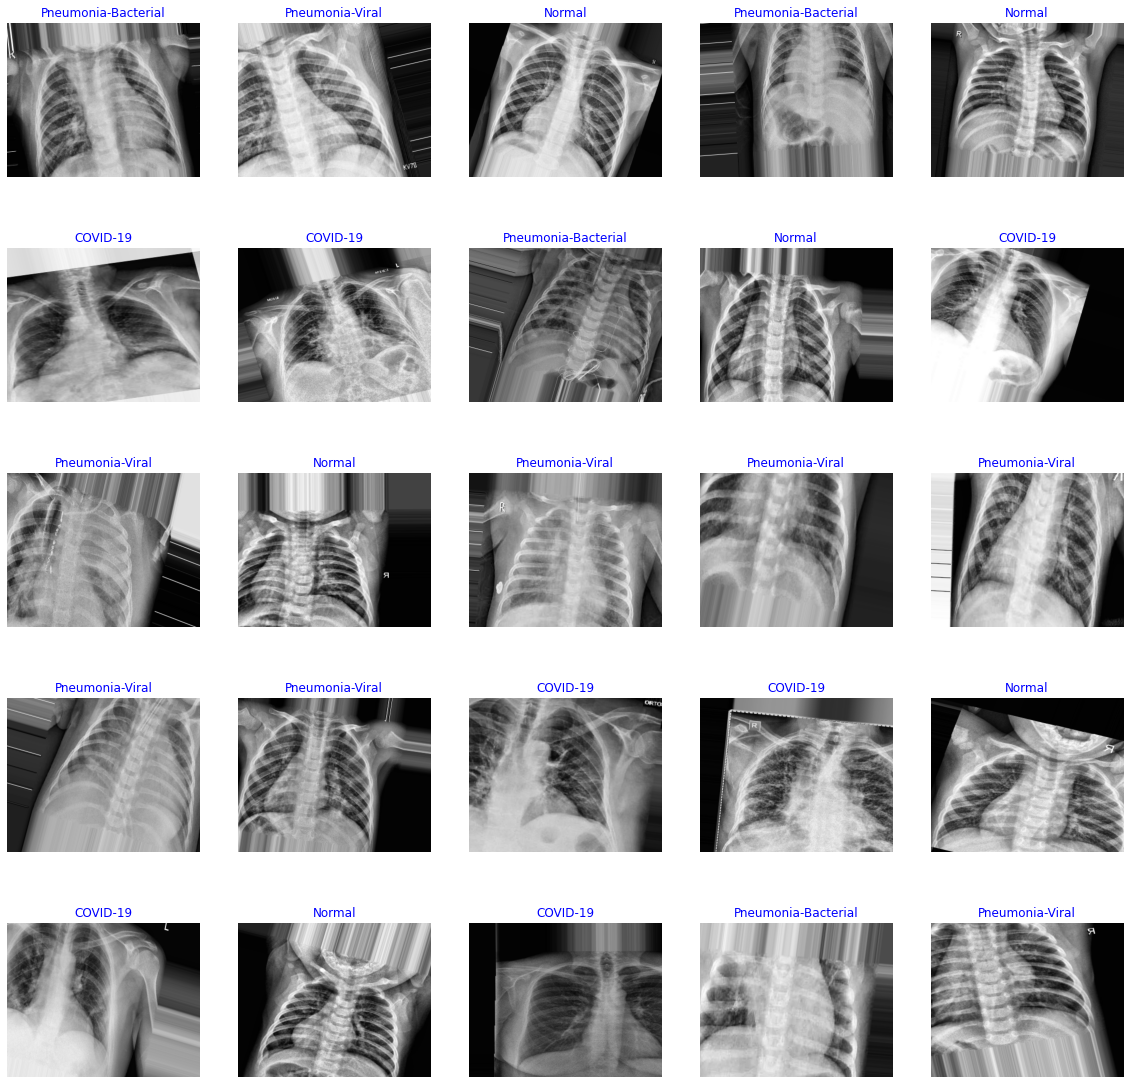

In [7]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

<a id="model"></a>
# <center>Create a model using transfer learning with EfficientNetB3</center>
### NOTE experts advise you make the base model initially not trainable. Then train for some number of epochs
### then fine tune model by making base model trainable and run more epochs
### I have found this to be WRONG!!!!
### Making the base model trainable from the outset leads to faster convegence and a lower validation loss
### for the same number of total epochs!

In [8]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

43950080/43941136 [==============================] - 0s 0us/step


<a id="callback"></a>
# <center>Create a custom Keras callback to continue or halt training</center>

In [9]:
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training     
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

<a id="callbacks"></a>
# <center>Instantiate custom callback and create 2 callbacks to control learning rate and early stop

In [11]:
epochs=40
ask_epoch=10
ask=ASK(model, epochs,  ask_epoch)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop, ask]

<a id="train"></a>
# <center>Train the model
### Note unlike how you are told it is BETTER to make the base model trainable from the outset
### It will converge faster and have a lower validation losss

In [12]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
60/60 [==============================] - 114s 2s/step - loss: 7.9862 - accuracy: 0.6967 - val_loss: 7.7504 - val_accuracy: 0.6600
Epoch 2/40
60/60 [==============================] - 94s 2s/step - loss: 6.3152 - accuracy: 0.7833 - val_loss: 6.1897 - val_accuracy: 0.7000
Epoch 3/40
60/60 [==============================] - 90s 1s/step - loss: 5.3105 - accuracy: 0.7878 - val_loss: 5.1524 - val_accuracy: 0.6700
Epoch 4/40
60/60 [==============================] - 91s 2s/step - loss: 4.4782 - accuracy: 0.8428 - val_loss: 4.3381 - val_accuracy: 0.7300
Epoch 5/40
60/60 [==============================] - 92s 2s/step - loss: 3.8838 - accuracy: 0.8422 - val_loss: 3.8513 - val_accuracy: 0.7500
Epoch 6/40
60/60 [==============================] - 92s 2s/step - loss: 3.3549 - accuracy: 0.8467 - val_loss: 3.2802 - val_accuracy: 0.72

 5


you entered  5  Training will continue to epoch  15
Epoch 11/40
60/60 [==============================] - 93s 2s/step - loss: 1.6383 - accuracy: 0.8972 - val_loss: 1.7305 - val_accuracy: 0.8000
Epoch 12/40
60/60 [==============================] - 94s 2s/step - loss: 1.3990 - accuracy: 0.9189 - val_loss: 1.5787 - val_accuracy: 0.7800
Epoch 13/40
60/60 [==============================] - 96s 2s/step - loss: 1.1946 - accuracy: 0.9367 - val_loss: 1.4349 - val_accuracy: 0.7900
Epoch 14/40
60/60 [==============================] - 97s 2s/step - loss: 1.0591 - accuracy: 0.9339 - val_loss: 1.2852 - val_accuracy: 0.8300
Epoch 15/40
60/60 [==============================] - 96s 2s/step - loss: 0.9123 - accuracy: 0.9372 - val_loss: 1.2799 - val_accuracy: 0.8300

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 2


you entered  2  Training will continue to epoch  17
Epoch 16/40
60/60 [==============================] - 96s 2s/step - loss: 0.8139 - accuracy: 0.9383 - val_loss: 1.1369 - val_accuracy: 0.7600
Epoch 17/40
60/60 [==============================] - 96s 2s/step - loss: 0.7000 - accuracy: 0.9489 - val_loss: 0.9789 - val_accuracy: 0.8400

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 2


you entered  2  Training will continue to epoch  19
Epoch 18/40
60/60 [==============================] - 97s 2s/step - loss: 0.6172 - accuracy: 0.9539 - val_loss: 1.1158 - val_accuracy: 0.7600
Epoch 19/40
60/60 [==============================] - 96s 2s/step - loss: 0.5426 - accuracy: 0.9633 - val_loss: 0.9240 - val_accuracy: 0.8200

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 3


you entered  3  Training will continue to epoch  22
Epoch 20/40
60/60 [==============================] - 95s 2s/step - loss: 0.4707 - accuracy: 0.9661 - val_loss: 0.9283 - val_accuracy: 0.8300
Epoch 21/40
60/60 [==============================] - 94s 2s/step - loss: 0.4438 - accuracy: 0.9628 - val_loss: 0.9111 - val_accuracy: 0.8000
Epoch 22/40
60/60 [==============================] - 93s 2s/step - loss: 0.4224 - accuracy: 0.9611 - val_loss: 0.8491 - val_accuracy: 0.7800

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 3


you entered  3  Training will continue to epoch  25
Epoch 23/40
60/60 [==============================] - 95s 2s/step - loss: 0.3910 - accuracy: 0.9644 - val_loss: 0.8171 - val_accuracy: 0.8000
Epoch 24/40
60/60 [==============================] - 96s 2s/step - loss: 0.3472 - accuracy: 0.9761 - val_loss: 0.7457 - val_accuracy: 0.8500
Epoch 25/40
60/60 [==============================] - 96s 2s/step - loss: 0.3386 - accuracy: 0.9656 - val_loss: 0.9758 - val_accuracy: 0.7800

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 3


you entered  3  Training will continue to epoch  28
Epoch 26/40
60/60 [==============================] - 94s 2s/step - loss: 0.2924 - accuracy: 0.9778 - val_loss: 0.8798 - val_accuracy: 0.8100

Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 27/40
60/60 [==============================] - 94s 2s/step - loss: 0.2847 - accuracy: 0.9750 - val_loss: 0.8521 - val_accuracy: 0.7900
Epoch 28/40
60/60 [==============================] - 93s 2s/step - loss: 0.2493 - accuracy: 0.9861 - val_loss: 0.9251 - val_accuracy: 0.7800

Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch.

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 h


you entered  h  Training halted on epoch  28  due to user input

Epoch 00028: early stopping
training elapsed time was 0.0 hours, 54.0 minutes, 1.39 seconds)


<a id="plot"></a>
# <center>Define a function to plot the training data

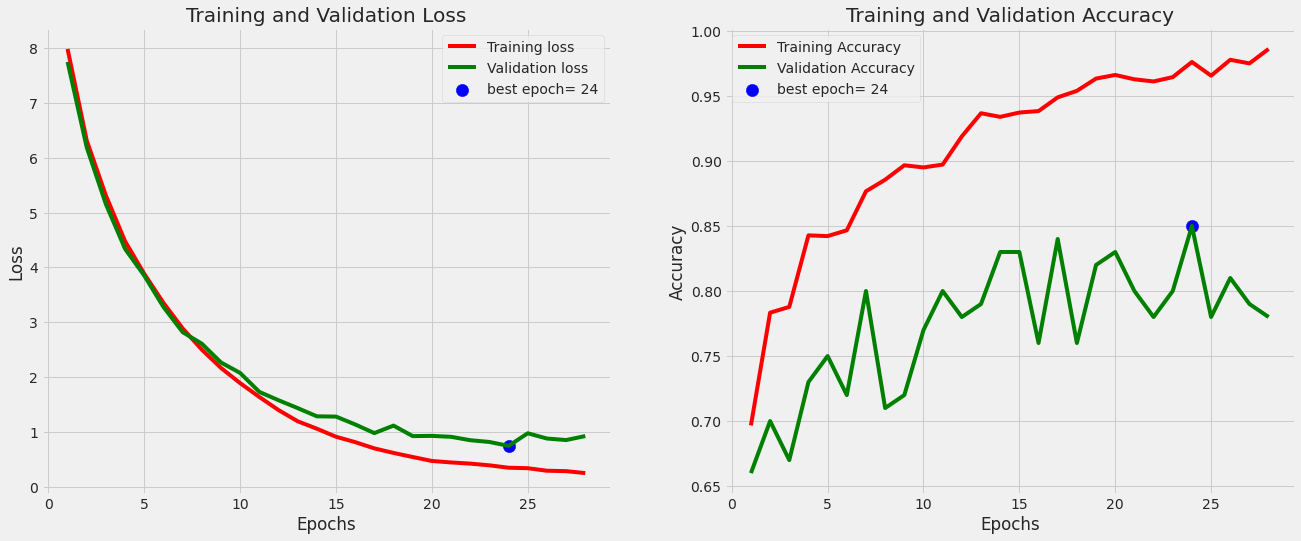

In [13]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

<a id="result"></a>
# <center>Make Predictions on the test set</a>
### Define a function which takes in a test generator and an integer test_steps
### and generates predictions on the test set including a confusion matric
### and a classification report

2/2 [==============================] - 5s 115ms/step
there were 14 in 100 tests for an accuracy of  86.00


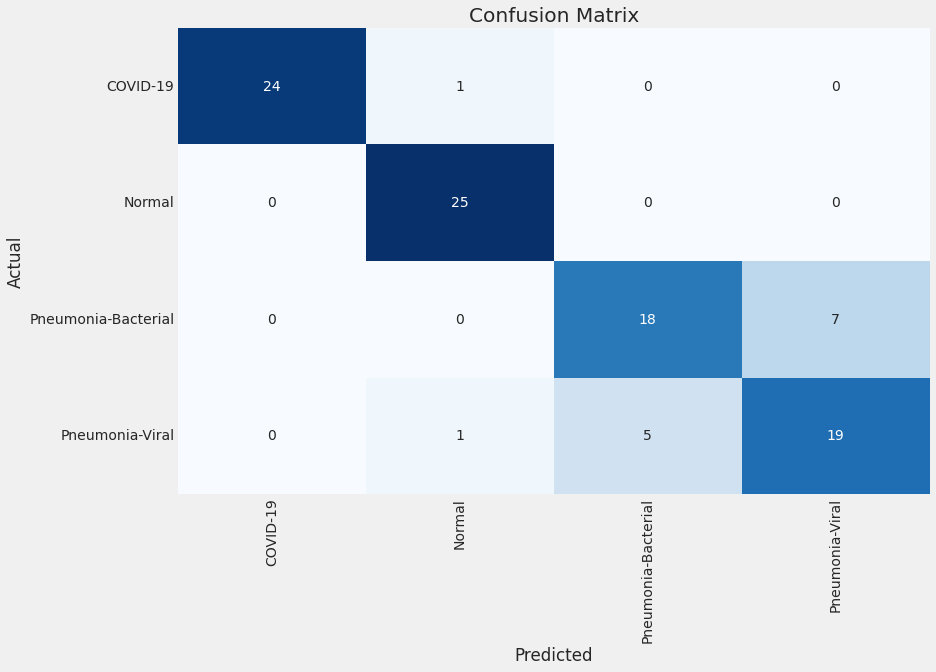

Classification Report:
----------------------
                      precision    recall  f1-score   support

           COVID-19     1.0000    0.9600    0.9796        25
             Normal     0.9259    1.0000    0.9615        25
Pneumonia-Bacterial     0.7826    0.7200    0.7500        25
    Pneumonia-Viral     0.7308    0.7600    0.7451        25

           accuracy                         0.8600       100
          macro avg     0.8598    0.8600    0.8591       100
       weighted avg     0.8598    0.8600    0.8591       100



In [14]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(train_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, steps=test_steps, verbose=1) # predict on the test set
    tests=len(preds)
    for i, p in enumerate(preds):
            pred_index=np.argmax(p)         
            true_index=test_gen.labels[i]  # labels are integer values
            if pred_index != true_index: # a misclassification has occurred                                           
                errors=errors + 1
            y_pred.append(pred_index)
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

<a id="save"></a>
# <center>Save the model

In [ ]:
subject='pneumonia' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc ) 
   